In [1]:
import os
import pandas as pd
import numpy as np
import time
import multiprocessing
import matplotlib.pyplot as plt
from haversine import haversine
import json
from collections import defaultdict
from glob import glob
import geopandas as gpd
from shapely.geometry import Point, Polygon, box
from geopy.distance import great_circle
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import json
import os

In [2]:
cbg_geom_fp = '2019cbg.geojson'
t0 = time.time()
cbg_geom_df = gpd.read_file(cbg_geom_fp)
print(f'CBG geometry data loading time is {time.time() - t0}')
cbg_geom_df = cbg_geom_df.to_crs('EPSG:2263')
cbg_geom_df['centroid'] = cbg_geom_df.centroid
cbg_geom_df.set_geometry('centroid', inplace=True)
cbg_geom_df = cbg_geom_df.to_crs('EPSG:4326')

CBG geometry data loading time is 374.24485039711


CBGs within the city boundary: 6298
CBG in city with population data: 6298 rows
Loaded SafeGraph data for New York: 1615768 rows
Filtered SafeGraph data: 321217 rows
Unique 'poi_cbg' values in newdata after formatting (sample): ['360610089005' '360850007004' '360610054001' '360610115001'
 '360610015022' '360610072003' '360610038003' '360610269003'
 '360610253004' '360610166003']
Filtered data with valid visitors: 266462 rows
Data after spatial join (intersects): 34330 rows
Data after filtering by poi_cbg within city: 34253 rows
Unique 'poi_type' values after mapping: ['Schools' 'Restaurants' 'Religious Organizations' 'Drugstores'
 'Healthcare' 'Services' 'Groceries' 'Cultural Institutions' 'Parks']
Data after filtering by 'poi_type': 15951 rows
City isochrones: 6298 rows
         cbg_id  total_poi_count  Parks  Restaurants  Religious Organizations  \
0  360050175002               27   11.0          8.0                      4.0   
1  360050141001               29   10.0         10.0    

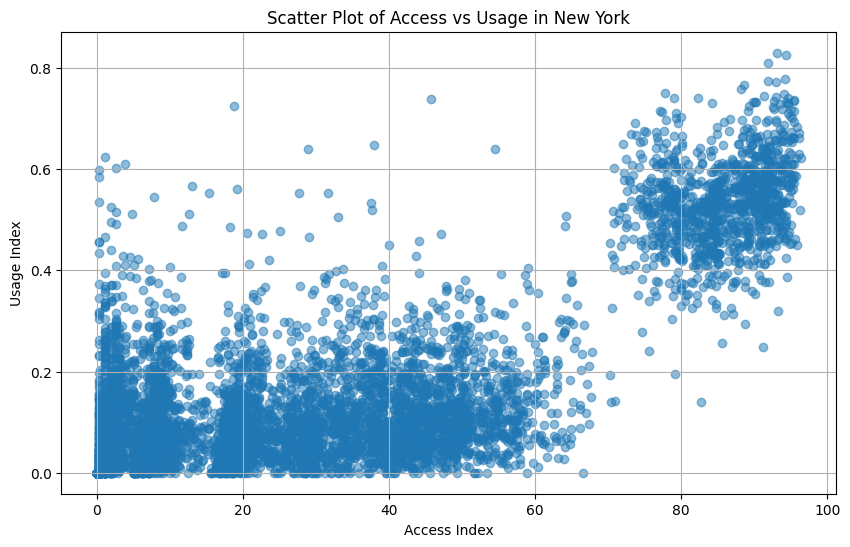

In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import json
import os

city_name = 'New York'
    # Load US city boundaries
us_city500_fp = './demo_code/Facility_distribution/500US_Cities_Bond/CityBoundaries.shp'
us500city = gpd.read_file(us_city500_fp)
us_500cities = us500city.to_crs(epsg=4326)
    
# Get the boundary of the city
city_boundary = us_500cities[us_500cities['NAME'] == city_name].geometry.iloc[0]

# Ensure centroids are Points
if not isinstance(cbg_geom_df['centroid'].iloc[0], Point):
        cbg_geom_df['centroid'] = cbg_geom_df['centroid'].apply(lambda x: Point(x))

cbg_geom_df['CensusBlockGroup'] = cbg_geom_df['CensusBlockGroup'].astype(str)
cbg_in_city = cbg_geom_df[cbg_geom_df['centroid'].apply(lambda x: x.within(city_boundary))]
print(f"CBGs within the city boundary: {len(cbg_in_city)}")
cbg_in_city.set_index('CensusBlockGroup', inplace=True)

# Load population data
cbg_pop_fp = 'cbg_b01.csv'
dtype_dic = {'census_block_group': str}
cbg_pop_df = pd.read_csv(cbg_pop_fp, dtype=dtype_dic)

cbg_in_city = cbg_in_city.reset_index()
cbg_in_city['CensusBlockGroup'] = cbg_in_city['CensusBlockGroup'].astype(str)
cbg_pop_df['census_block_group'] = cbg_pop_df['census_block_group'].astype(str)

merged_df = pd.merge(cbg_in_city, 
                         cbg_pop_df[['census_block_group', 'B01001e1']], 
                         how='left', 
                         left_on='CensusBlockGroup', 
                         right_on='census_block_group')

merged_df.drop(columns=['census_block_group'], inplace=True)
merged_df.rename(columns={'B01001e1': 'population'}, inplace=True)
merged_df.set_index('CensusBlockGroup', inplace=True)
cbg_in_city = merged_df
print(f"CBG in city with population data: {cbg_in_city.shape[0]} rows")

# Set the geometry column to 'centroid'
cbg_in_city = cbg_in_city.set_geometry('centroid', crs='EPSG:4326')
cbg_to_centroid = {str(index): row['centroid'] for index, row in cbg_in_city.iterrows()}

# Load SafeGraph data for the city
filenames = [f'2021{month:02d}_{city_name}.csv' for month in range(1, 12)]
year2021_data = pd.DataFrame()

for filename in filenames:
    df = pd.read_csv(filename)
    year2021_data = pd.concat([year2021_data, df], ignore_index=True)

year2021_data = year2021_data[year2021_data['city'] == city_name]
print(f"Loaded SafeGraph data for {city_name}: {year2021_data.shape[0]} rows")

# Filter invalid data
year2021_data = year2021_data.dropna(subset=['naics_code', 'poi_cbg', 'visitor_home_cbgs', 'longitude', 'latitude'])
print(f"Filtered SafeGraph data: {year2021_data.shape[0]} rows")

# Convert 'poi_cbg' to string, remove decimal points, and ensure 12 characters with leading zeros
year2021_data['poi_cbg'] = year2021_data['poi_cbg'].astype(str).str.split('.').str[0].str.zfill(12)
print(f"Unique 'poi_cbg' values in newdata after formatting (sample): {year2021_data['poi_cbg'].unique()[:10]}")

    # Filter visitor data
year2021_data['visitor_home_cbgs'] = year2021_data['visitor_home_cbgs'].apply(
        lambda x: json.loads(x) if isinstance(x, str) else x)


newdata = year2021_data[year2021_data['visitor_home_cbgs'].apply(lambda x: bool(x))].copy()
print(f"Filtered data with valid visitors: {newdata.shape[0]} rows")

    # Group by 'placekey' to avoid duplicates
newdata = newdata.groupby('placekey').agg({
        'poi_cbg': 'first',
        'visitor_home_cbgs': lambda x: {k: sum(d.get(k, 0) for d in x if isinstance(d, dict)) for k in set(k for d in x for k in d.keys())},
        'naics_code': 'first',
        'longitude': 'first',
        'latitude': 'first',
        'raw_visit_counts': 'sum',
        'raw_visitor_counts': 'sum',
    }).reset_index()
    
    # Ensure no NaN after aggregation
newdata = newdata.dropna(subset=['poi_cbg', 'visitor_home_cbgs'])
newdata['visit_visitor_ratio'] = newdata.apply(
    lambda row: row['raw_visit_counts'] / row['raw_visitor_counts'] if row['raw_visitor_counts'] != 0 else 0, axis=1)

    # 对于 visitor_home_cbgs 字典中的每个值，乘以 ratio
newdata['visit_home_cbgs'] = newdata.apply(
    lambda row: {k: v * row['visit_visitor_ratio'] for k, v in row['visitor_home_cbgs'].items()} 
if isinstance(row['visitor_home_cbgs'], dict) else {}, axis=1)
    # Create geometry
newdata['geometry'] = newdata.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
newdata = gpd.GeoDataFrame(newdata, geometry='geometry', crs='EPSG:4326')

    # Convert types to ensure they match
newdata['poi_cbg'] = newdata['poi_cbg'].astype(str)
cbg_in_city.index = cbg_in_city.index.astype(str)

    # Spatial join with CBG geometry
newdata = gpd.sjoin(newdata, cbg_in_city.set_geometry('geometry', crs='EPSG:4326'), how='left', predicate='intersects')
print(f"Data after spatial join (intersects): {newdata.shape[0]} rows")

    # Check poi_cbg within city
newdata = newdata[newdata['poi_cbg'].isin(cbg_in_city.index)]
print(f"Data after filtering by poi_cbg within city: {newdata.shape[0]} rows")
    
    # Assign poi types
naics_to_poi_type = {
        '621111': 'Healthcare',
        '621112': 'Healthcare',
        '621410': 'Healthcare',
        '621492': 'Healthcare',
        '621493': 'Healthcare',
        '621498': 'Healthcare',
        '622110': 'Healthcare',
        '446110': 'Drugstores',
        '611110': 'Schools',
        '813110': 'Religious Organizations',
        '722511': 'Restaurants',
        '722513': 'Restaurants',
        '722514': 'Restaurants',
        '722515': 'Restaurants',
        '445110': 'Groceries',
        '445120': 'Groceries',
        '712190': 'Parks',
        '711190': 'Cultural Institutions',
        '713110': 'Cultural Institutions',
        '712110': 'Cultural Institutions',
        '491110': 'Services',
        '522110': 'Services',
        '812111': 'Services',
        '812112': 'Services',
        '812113': 'Services',
        '812320': 'Services'
    }

newdata['poi_type'] = newdata['naics_code'].apply(lambda x: naics_to_poi_type.get(str(int(x)), 'Other') if pd.notnull(x) else 'Other')
newdata = newdata[newdata['poi_type'] != 'Other']

print(f"Unique 'poi_type' values after mapping: {newdata['poi_type'].unique()}")
print(f"Data after filtering by 'poi_type': {newdata.shape[0]} rows")

    # Calculate 15-minute access
cbg_isochrones = gpd.read_file('cbg_isochrones.geojson')
cbg_isochrones['cbg_id'] = cbg_isochrones['cbg_id'].astype(str)
cbg_ids = cbg_in_city.index.astype(str).tolist()
city_isochrones = cbg_isochrones[cbg_isochrones['cbg_id'].isin(cbg_ids)]
print(f"City isochrones: {city_isochrones.shape[0]} rows")

    # Calculating access index...
results = []
for idx, cbg in city_isochrones.iterrows():
        cbg_polygon = cbg['geometry']
        cbg_id = cbg['cbg_id']
        poi_in_cbg = newdata[newdata.within(cbg_polygon)]
        poi_counts_by_type = poi_in_cbg['poi_type'].value_counts().to_dict() if 'poi_type' in poi_in_cbg.columns else {}
        total_poi_count = poi_in_cbg.shape[0]
        results.append({
            'cbg_id': cbg_id,
            'total_poi_count': total_poi_count,
            **poi_counts_by_type
        })

No_Facility = pd.DataFrame(results)
print(No_Facility.head())  # Debugging line to see the result

    # Compute trip data
trip_counts = newdata['poi_type'].value_counts()
trip_percentages = trip_counts / trip_counts.sum()
trip_data = trip_percentages.reset_index()
trip_data.columns = ['category', 'percentage_of_trips']
trip_data['weight'] = trip_data['percentage_of_trips'] / trip_data['percentage_of_trips'].sum()

for col in No_Facility.columns[2:]:
        No_Facility[f'{col}_percentile'] = No_Facility[col].rank(pct=True) * 100

for category in trip_data['category']:
        if f'{category}_percentile' in No_Facility.columns:
            No_Facility[f'{category}_access'] = No_Facility[f'{category}_percentile'] * trip_data[trip_data['category'] == category]['weight'].values[0]

No_Facility['access_index'] = No_Facility[[f'{category}_access' for category in trip_data['category']]].sum(axis=1)

    # Merge access index calculation results
merged_access_df = pd.merge(cbg_in_city[['population']], 
                                No_Facility[['cbg_id', 'access_index']], 
                                left_index=True, 
                                right_on='cbg_id', 
                                how='inner')

merged_access_df['weighted_access'] = merged_access_df['access_index'] * merged_access_df['population']

if merged_access_df['population'].sum() > 0:
        access_index = merged_access_df['weighted_access'].sum() / merged_access_df['population'].sum()
else:
        access_index = 0

print(f"{city_name} access index: {access_index:.4f}")

    # Calculate the usage index with demand as the weight
results = []
for idx, cbg in city_isochrones.iterrows():
        target_cbg_id = cbg['cbg_id']
        target_cbg_polygon = cbg['geometry']
        
        # Filter records from target CBG
        target_rows = newdata[newdata['visit_home_cbgs'].apply(lambda x: target_cbg_id in x)]

        within_1_25km_count = 0
        outside_1_25km_count = 0
        total_visitors = 0

        for idx, row in target_rows.iterrows():
            visitor_count = row['visit_home_cbgs'][target_cbg_id]
            total_visitors += visitor_count
            destination_point = row['geometry']

            if destination_point.within(target_cbg_polygon):
                within_1_25km_count += visitor_count
            else:
                outside_1_25km_count += visitor_count

        within_ratio = within_1_25km_count / total_visitors if total_visitors > 0 else 0

        results.append({
            'cbg_id': target_cbg_id,
            'total_visitors': total_visitors,
            'within_1_25km_count': within_1_25km_count,
            'outside_1_25km_count': outside_1_25km_count,
            'within_ratio': within_ratio
        })

cbg_visitor_ratios = pd.DataFrame(results)
cbg_visitor_ratios['cbg_id'] = cbg_visitor_ratios['cbg_id'].astype(str)
cbg_in_city.index = cbg_in_city.index.astype(str)

merged_usage_df = pd.merge(cbg_in_city[['population']], 
                               cbg_visitor_ratios[['cbg_id', 'within_ratio', 'total_visitors']], 
                               left_index=True, 
                               right_on='cbg_id', 
                               how='left')

merged_usage_df['within_ratio'] = merged_usage_df['within_ratio'].fillna(0)

    # Calculate the weighted usage index using total_visitors as the demand
if merged_usage_df['total_visitors'].sum() > 0:
        merged_usage_df['weighted_usage'] = merged_usage_df['within_ratio'] * merged_usage_df['total_visitors']
        usage_index = merged_usage_df['weighted_usage'].sum() / merged_usage_df['total_visitors'].sum()
else:
        usage_index = 0

print(f"{city_name} usage index (based on demand): {usage_index:.4f}")

    # Ensure merged_access_df and merged_usage_df have consistent lengths
common_index = merged_access_df.index.intersection(merged_usage_df.index)
merged_access_df = merged_access_df.loc[common_index]
merged_usage_df = merged_usage_df.loc[common_index]

    # Plotting the scatter plot of Access vs Usage
plt.figure(figsize=(10, 6))
plt.scatter(merged_access_df['access_index'], merged_usage_df['within_ratio'], alpha=0.5)
plt.title(f'Scatter Plot of Access vs Usage in {city_name}')
plt.xlabel('Access Index')
plt.ylabel('Usage Index')
plt.grid(True)
plt.show()

Before merge, geometry types:
Point    6298
Name: count, dtype: int64
After merge, geometry types:
Point    6298
Name: count, dtype: int64


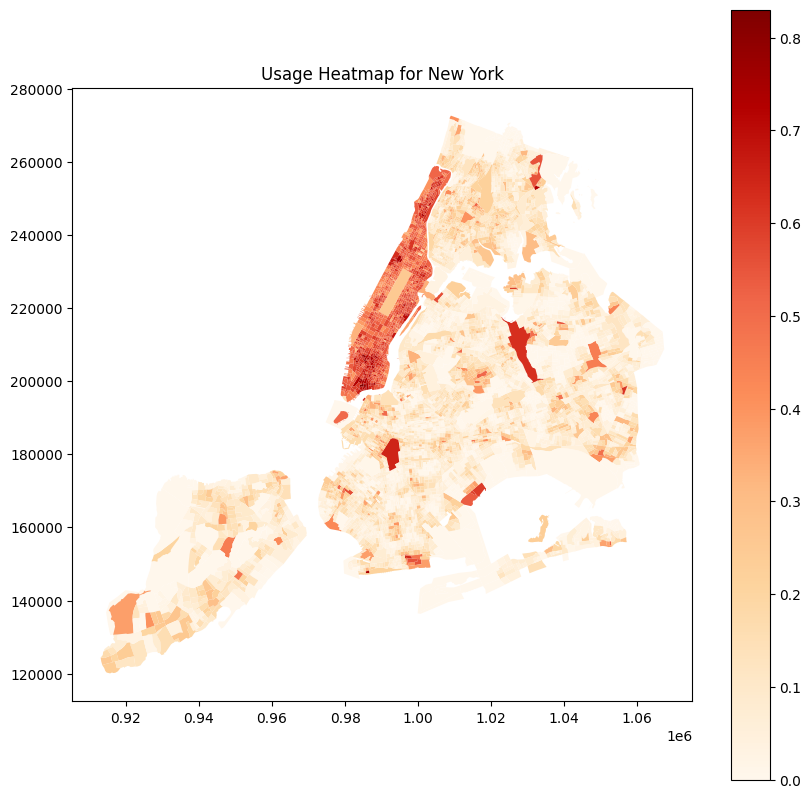

In [4]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

# 确保 'cbg_geom_df' 和 'cbg_in_city' 中的 'CensusBlockGroup' 都是字符串
cbg_geom_df['CensusBlockGroup'] = cbg_geom_df['CensusBlockGroup'].astype(str)
cbg_in_city.index = cbg_in_city.index.astype(str)

# 使用 'geometry' 列，而不是 'centroid' 列来绘制多边形
# 只从 cbg_geom_df 中提取纽约市的 CBG
ny_cbg_geom_df = cbg_geom_df[cbg_geom_df['CensusBlockGroup'].isin(cbg_in_city.index)].copy()

# 检查合并前的几何数据
print("Before merge, geometry types:")
print(ny_cbg_geom_df.geometry.geom_type.value_counts())  # 打印几何类型的统计

# 检查 cbg_visitor_ratios 是否已经重置索引
if 'cbg_id' not in cbg_visitor_ratios.columns:
    cbg_visitor_ratios = cbg_visitor_ratios.reset_index()

# 将 'within_ratio' 合并到 ny_cbg_geom_df 中，使用 'CensusBlockGroup' 和 'cbg_id' 进行合并
ny_cbg_geom_df = pd.merge(ny_cbg_geom_df, cbg_visitor_ratios[['cbg_id', 'within_ratio']], 
                          left_on='CensusBlockGroup', right_on='cbg_id', how='left')

# 填充 NaN 值为 0，避免绘图出错
ny_cbg_geom_df['within_ratio'] = ny_cbg_geom_df['within_ratio'].fillna(0)

# 检查合并后的几何数据
print("After merge, geometry types:")
print(ny_cbg_geom_df.geometry.geom_type.value_counts())  # 打印几何类型的统计
# 确保 'geometry' 列包含的是多边形而不是质心点
# 直接使用已经包含的 MULTIPOLYGON 数据
ny_cbg_geom_df.set_geometry('geometry', inplace=True)

# 使用 GeoPandas 的 plot 函数绘制多边形
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# 根据 'within_ratio' 设置颜色，确保使用 'geometry' 列来绘制多边形
ny_cbg_geom_df.plot(column='within_ratio', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor=None, legend=True)

# 设置地图显示的纵横比为 1，避免边界失真
ax.set_aspect('equal')

# 添加图表标题
plt.title(f'Usage Heatmap for {city_name}')
plt.show()



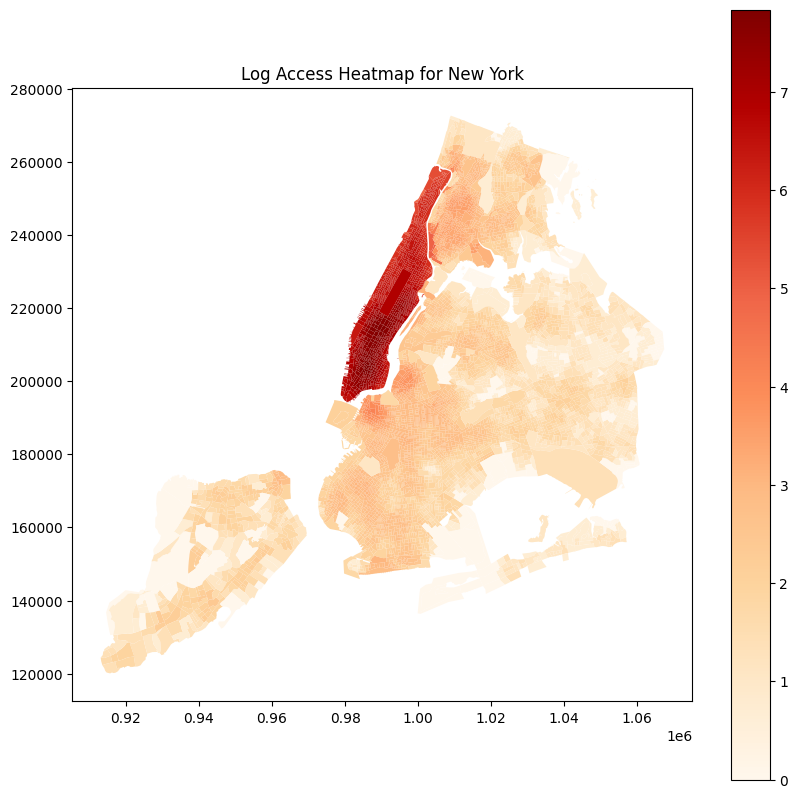

In [5]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np

# 确保 'cbg_geom_df' 和 'No_Facility' 中的 'CensusBlockGroup' 和 'cbg_id' 都是字符串
cbg_geom_df['CensusBlockGroup'] = cbg_geom_df['CensusBlockGroup'].astype(str)
No_Facility['cbg_id'] = No_Facility['cbg_id'].astype(str)

# 只从 cbg_geom_df 中提取纽约市的 CBG
ny_cbg_geom_df = cbg_geom_df[cbg_geom_df['CensusBlockGroup'].isin(No_Facility['cbg_id'])].copy()

# 合并 'total_poi_count' 到 ny_cbg_geom_df
ny_cbg_geom_df = pd.merge(ny_cbg_geom_df, No_Facility[['cbg_id', 'total_poi_count']], 
                          left_on='CensusBlockGroup', right_on='cbg_id', how='left')

# 填充 NaN 值为 0
ny_cbg_geom_df['total_poi_count'] = ny_cbg_geom_df['total_poi_count'].fillna(0)

# 对 'total_poi_count' 取对数，处理为 log(1 + total_poi_count)，避免 log(0) 的问题
ny_cbg_geom_df['log_total_poi_count'] = np.log1p(ny_cbg_geom_df['total_poi_count'])

# 确保 'geometry' 列为 GeoDataFrame 中的活动几何列
ny_cbg_geom_df.set_geometry('geometry', inplace=True)

# 使用 GeoPandas 的 plot 函数绘制多边形
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# 根据 'log_total_poi_count' 设置颜色，移除边框 (edgecolor=None)
ny_cbg_geom_df.plot(column='log_total_poi_count', cmap='OrRd', linewidth=0, ax=ax, edgecolor=None, legend=True)

# 设置地图显示的纵横比为 1，避免边界失真
ax.set_aspect('equal')

# 添加图表标题
plt.title(f'Log Access Heatmap for {city_name}')
plt.show()


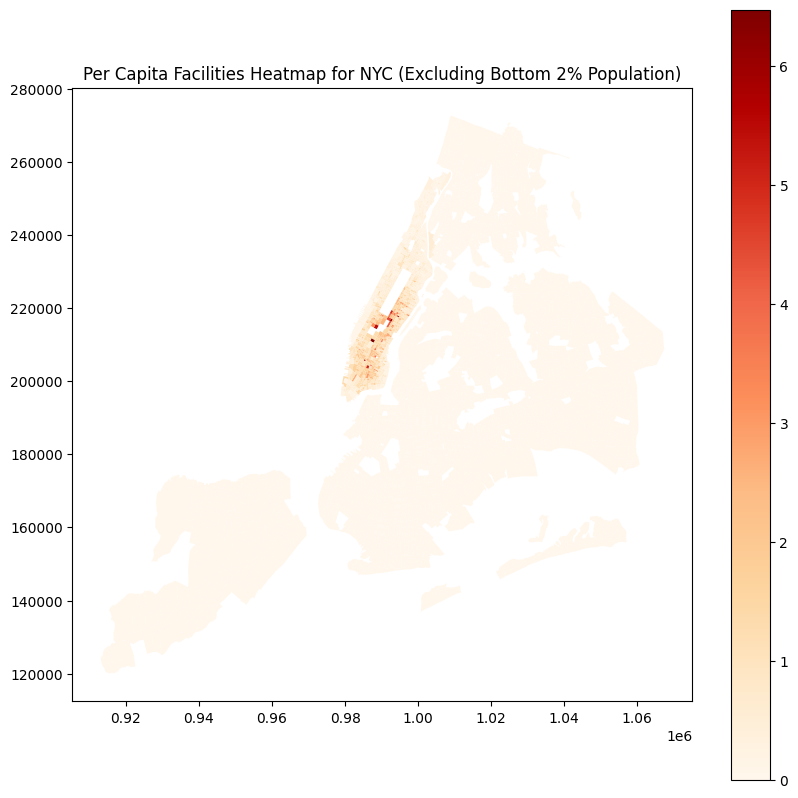

In [6]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np

# 确保 'cbg_geom_df' 和 'No_Facility' 中的 'CensusBlockGroup' 和 'cbg_id' 都是字符串
cbg_geom_df['CensusBlockGroup'] = cbg_geom_df['CensusBlockGroup'].astype(str)
No_Facility['cbg_id'] = No_Facility['cbg_id'].astype(str)

# 只从 cbg_geom_df 中提取纽约市的 CBG
ny_cbg_geom_df = cbg_geom_df[cbg_geom_df['CensusBlockGroup'].isin(No_Facility['cbg_id'])].copy()

# 合并 'total_poi_count' 到 ny_cbg_geom_df
ny_cbg_geom_df = pd.merge(ny_cbg_geom_df, No_Facility[['cbg_id', 'total_poi_count']], 
                          left_on='CensusBlockGroup', right_on='cbg_id', how='left')

# 填充 NaN 值为 0
ny_cbg_geom_df['total_poi_count'] = ny_cbg_geom_df['total_poi_count'].fillna(0)

# 从 cbg_in_city 中提取人口数据
population_data = cbg_in_city[['population']].reset_index()
population_data['CensusBlockGroup'] = population_data['CensusBlockGroup'].astype(str)

# 合并人口数据到 ny_cbg_geom_df
ny_cbg_geom_df = pd.merge(ny_cbg_geom_df, population_data, left_on='CensusBlockGroup', right_on='CensusBlockGroup', how='left')

# 计算人均设施数，避免除以零
ny_cbg_geom_df['per_capita_facilities'] = np.where(ny_cbg_geom_df['population'] > 0,
                                                     ny_cbg_geom_df['total_poi_count'] / ny_cbg_geom_df['population'],
                                                     0)

# 计算人口的阈值（1%的人口最少的CBG）
population_threshold = ny_cbg_geom_df['population'].quantile(0.02)

# 过滤掉人口最少的1% CBG
ny_cbg_geom_df = ny_cbg_geom_df[ny_cbg_geom_df['population'] > population_threshold]

# 确保 'geometry' 列为 GeoDataFrame 中的活动几何列
ny_cbg_geom_df.set_geometry('geometry', inplace=True)

# 使用 GeoPandas 的 plot 函数绘制多边形
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# 根据 'per_capita_facilities' 设置颜色，移除边框 (edgecolor=None)
ny_cbg_geom_df.plot(column='per_capita_facilities', cmap='OrRd', linewidth=0, ax=ax, edgecolor=None, legend=True)

# 设置地图显示的纵横比为 1，避免边界失真
ax.set_aspect('equal')

# 添加图表标题
plt.title('Per Capita Facilities Heatmap for NYC (Excluding Bottom 2% Population)')
plt.show()


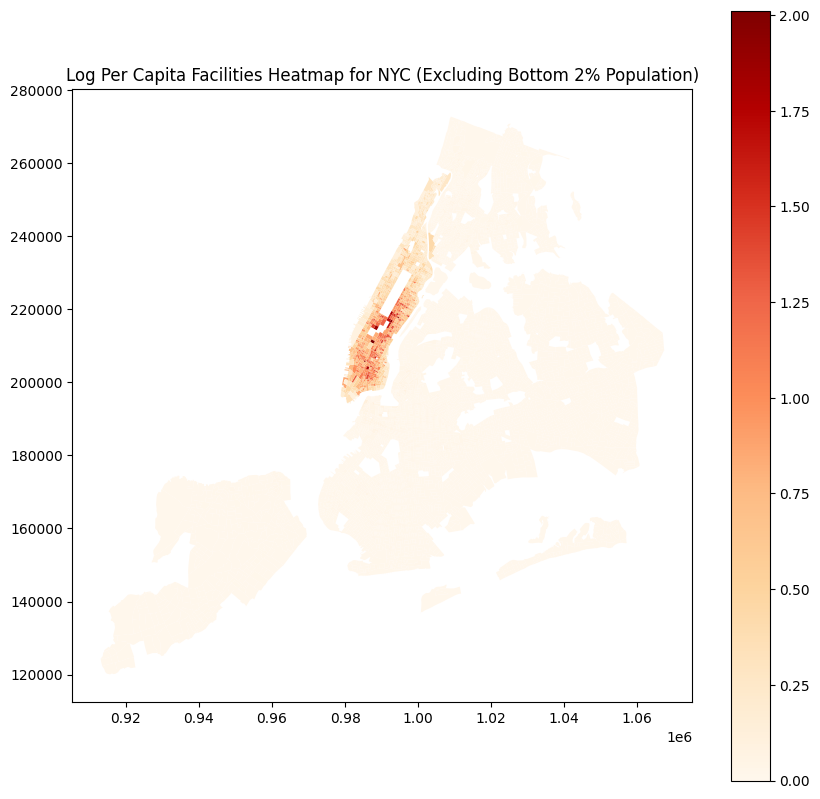

In [7]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np

# 确保 'cbg_geom_df' 和 'No_Facility' 中的 'CensusBlockGroup' 和 'cbg_id' 都是字符串
cbg_geom_df['CensusBlockGroup'] = cbg_geom_df['CensusBlockGroup'].astype(str)
No_Facility['cbg_id'] = No_Facility['cbg_id'].astype(str)

# 只从 cbg_geom_df 中提取纽约市的 CBG
ny_cbg_geom_df = cbg_geom_df[cbg_geom_df['CensusBlockGroup'].isin(No_Facility['cbg_id'])].copy()

# 合并 'total_poi_count' 到 ny_cbg_geom_df
ny_cbg_geom_df = pd.merge(ny_cbg_geom_df, No_Facility[['cbg_id', 'total_poi_count']], 
                          left_on='CensusBlockGroup', right_on='cbg_id', how='left')

# 填充 NaN 值为 0
ny_cbg_geom_df['total_poi_count'] = ny_cbg_geom_df['total_poi_count'].fillna(0)

# 从 cbg_in_city 中提取人口数据
population_data = cbg_in_city[['population']].reset_index()
population_data['CensusBlockGroup'] = population_data['CensusBlockGroup'].astype(str)

# 合并人口数据到 ny_cbg_geom_df
ny_cbg_geom_df = pd.merge(ny_cbg_geom_df, population_data, left_on='CensusBlockGroup', right_on='CensusBlockGroup', how='left')

# 计算人均设施数，避免除以零
ny_cbg_geom_df['per_capita_facilities'] = np.where(ny_cbg_geom_df['population'] > 0,
                                                     ny_cbg_geom_df['total_poi_count'] / ny_cbg_geom_df['population'],
                                                     0)

# 计算人口的阈值（2%的人口最少的CBG）
population_threshold = ny_cbg_geom_df['population'].quantile(0.02)

# 过滤掉人口最少的2% CBG
ny_cbg_geom_df = ny_cbg_geom_df[ny_cbg_geom_df['population'] > population_threshold]

# 对人均设施数取对数，处理为 log(1 + per_capita_facilities)，避免 log(0) 的问题
ny_cbg_geom_df['log_per_capita_facilities'] = np.log1p(ny_cbg_geom_df['per_capita_facilities'])

# 确保 'geometry' 列为 GeoDataFrame 中的活动几何列
ny_cbg_geom_df.set_geometry('geometry', inplace=True)

# 使用 GeoPandas 的 plot 函数绘制多边形
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# 根据 'log_per_capita_facilities' 设置颜色，移除边框 (edgecolor=None)
ny_cbg_geom_df.plot(column='log_per_capita_facilities', cmap='OrRd', linewidth=0, ax=ax, edgecolor=None, legend=True)

# 设置地图显示的纵横比为 1，避免边界失真
ax.set_aspect('equal')

# 添加图表标题
plt.title('Log Per Capita Facilities Heatmap for NYC (Excluding Bottom 2% Population)')
plt.show()


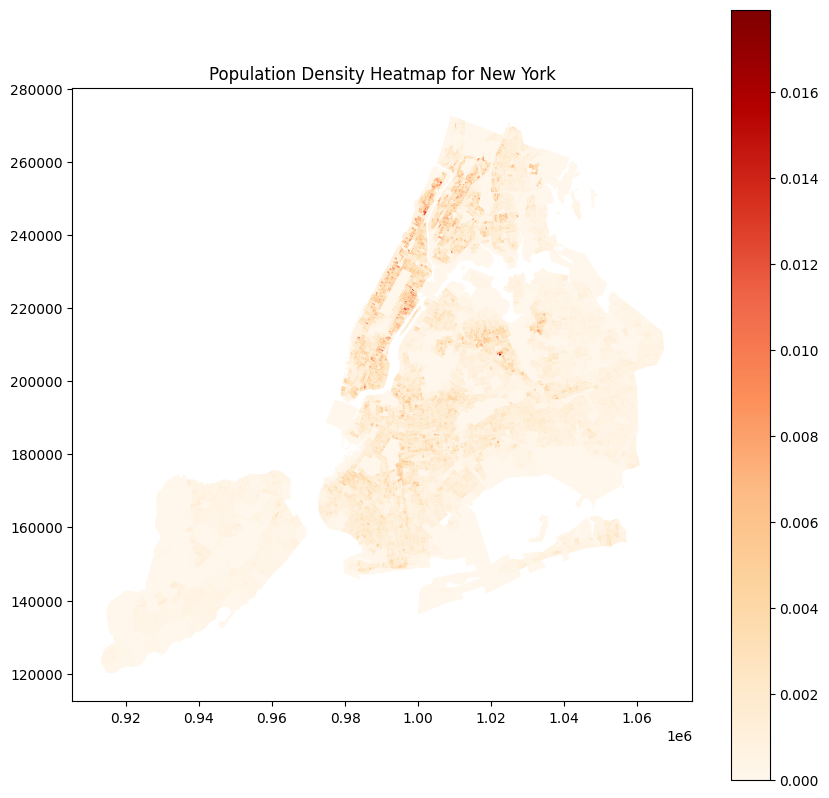

In [8]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

# 确保 'CensusBlockGroup' 是字符串类型
cbg_in_city.index = cbg_in_city.index.astype(str)

# 使用 'geometry' 列作为活动几何列来绘制多边形
cbg_in_city.set_geometry('geometry', inplace=True)

# 计算每个 CBG 的面积，单位是平方米
cbg_in_city['area_sqm'] = cbg_in_city['geometry'].area

# 计算人口密度（每平方米人口数）
cbg_in_city['population_density'] = cbg_in_city['population'] / cbg_in_city['area_sqm']

# 使用 GeoPandas 的 plot 函数绘制多边形
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# 根据 'population_density' 设置颜色
cbg_in_city.plot(column='population_density', cmap='OrRd', linewidth=0, ax=ax, edgecolor=None, legend=True)

# 设置地图显示的纵横比为 1，避免边界失真
ax.set_aspect('equal')

# 添加图表标题
plt.title('Population Density Heatmap for New York')
plt.show()


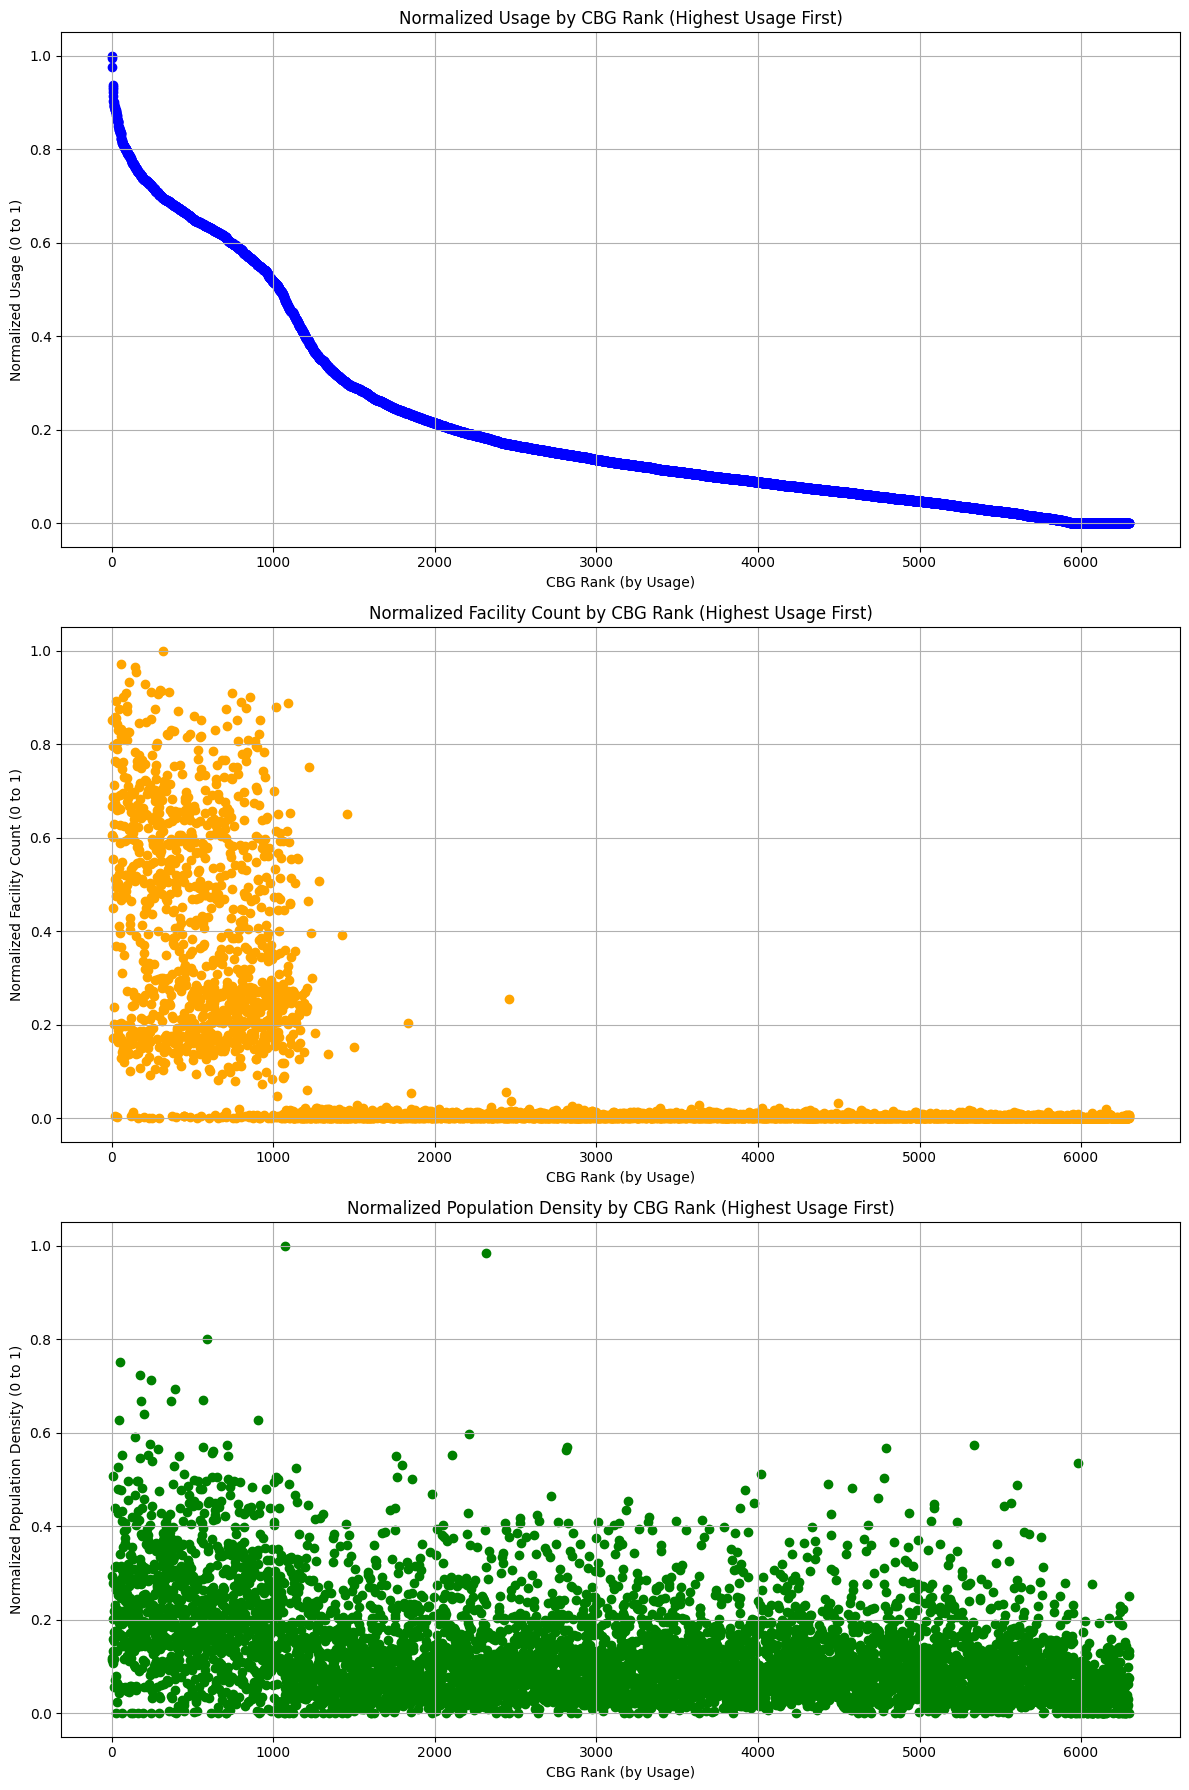

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 从各个 DataFrame 提取所需的数据
usage_data = merged_usage_df[['cbg_id', 'within_ratio']].copy()
facility_data = No_Facility[['cbg_id', 'total_poi_count']].copy()
population_data = cbg_in_city.reset_index()[['CensusBlockGroup', 'population', 'population_density']].rename(columns={'CensusBlockGroup': 'cbg_id'})

# 合并所有数据到一个 DataFrame 中
merged_data = usage_data.merge(facility_data, on='cbg_id', how='inner').merge(population_data, on='cbg_id', how='inner')

# 标准化到 [0, 1] 之间
merged_data['usage_normalized'] = (merged_data['within_ratio'] - merged_data['within_ratio'].min()) / (merged_data['within_ratio'].max() - merged_data['within_ratio'].min())
merged_data['facility_count_normalized'] = (merged_data['total_poi_count'] - merged_data['total_poi_count'].min()) / (merged_data['total_poi_count'].max() - merged_data['total_poi_count'].min())
merged_data['population_density_normalized'] = (merged_data['population_density'] - merged_data['population_density'].min()) / (merged_data['population_density'].max() - merged_data['population_density'].min())

# 按照 'within_ratio' 从大到小排名，并添加排名列
merged_data['rank'] = merged_data['within_ratio'].rank(method='first', ascending=False).astype(int)
merged_data = merged_data.sort_values('rank')

# 创建图表
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# 绘制 usage 的散点图
axs[0].scatter(merged_data['rank'], merged_data['usage_normalized'], color='blue')
axs[0].set_title('Normalized Usage by CBG Rank (Highest Usage First)')
axs[0].set_xlabel('CBG Rank (by Usage)')
axs[0].set_ylabel('Normalized Usage (0 to 1)')
axs[0].grid(True)

# 绘制设施数的散点图
axs[1].scatter(merged_data['rank'], merged_data['facility_count_normalized'], color='orange')
axs[1].set_title('Normalized Facility Count by CBG Rank (Highest Usage First)')
axs[1].set_xlabel('CBG Rank (by Usage)')
axs[1].set_ylabel('Normalized Facility Count (0 to 1)')
axs[1].grid(True)

# 绘制人口密度的散点图
axs[2].scatter(merged_data['rank'], merged_data['population_density_normalized'], color='green')
axs[2].set_title('Normalized Population Density by CBG Rank (Highest Usage First)')
axs[2].set_xlabel('CBG Rank (by Usage)')
axs[2].set_ylabel('Normalized Population Density (0 to 1)')
axs[2].grid(True)

# 调整布局
plt.tight_layout()
plt.show()


In [35]:
merged_data

,cbg_id,within_ratio,total_poi_count,population,population_density,usage_normalized,facility_count_normalized,population_density_normalized,rank
5356,360610027001,0.830288,1697,1341,0.002102,1.000000,0.668110,0.117295,1
1974,360610059002,0.825667,2163,362,0.002039,0.994434,0.851575,0.113805,2
5262,360610008002,0.810141,1540,1018,0.005253,0.975735,0.606299,0.293216,3
5322,360610063002,0.778692,2022,1025,0.001941,0.937857,0.796063,0.108331,4
5263,360610008003,0.775257,1529,1697,0.009095,0.933720,0.601969,0.507641,5
...,...,...,...,...,...,...,...,...,...
6180,360470472002,0.000000,11,1379,0.002244,0.000000,0.004331,0.125242,6294
6183,360470476002,0.000000,6,827,0.001356,0.000000,0.002362,0.075660,6295
6210,360470666001,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,6296
6239,360470509002,0.000000,20,3389,0.004511,0.000000,0.007874,0.251799,6297


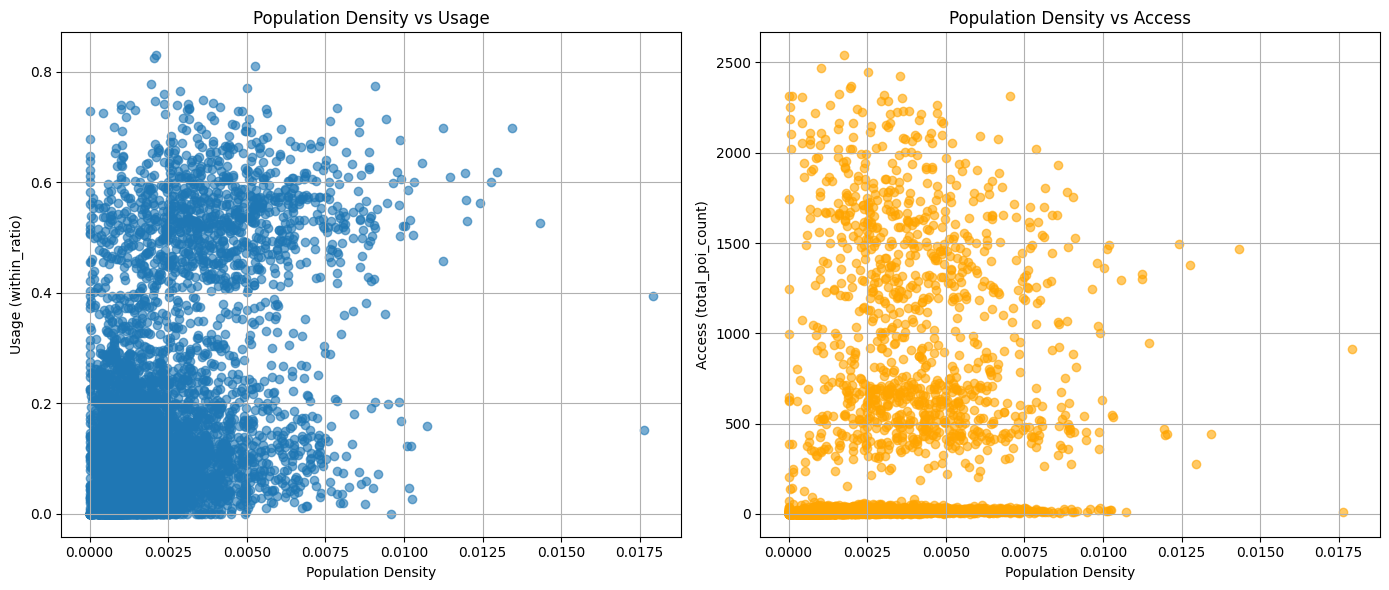

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设 merged_data 已经存在并包含所需的列
# 确保 merged_data 中的列名与以下代码一致
# 设置图形大小
plt.figure(figsize=(14, 6))

# 绘制人口密度与usage的散点图
plt.subplot(1, 2, 1)
plt.scatter(merged_data['population_density'], merged_data['within_ratio'], alpha=0.6)
plt.title('Population Density vs Usage')
plt.xlabel('Population Density')
plt.ylabel('Usage (within_ratio)')
plt.grid(True)

# 绘制人口密度与access的散点图
plt.subplot(1, 2, 2)
plt.scatter(merged_data['population_density'], merged_data['total_poi_count'], alpha=0.6, color='orange')
plt.title('Population Density vs Access')
plt.xlabel('Population Density')
plt.ylabel('Access (total_poi_count)')
plt.grid(True)

# 显示图形
plt.tight_layout()
plt.show()


C:\Users\jack\AppData\Local\Temp\ipykernel_21828\4023512946.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data['access_per_population'] = merged_data['total_poi_count'] / merged_data['population']


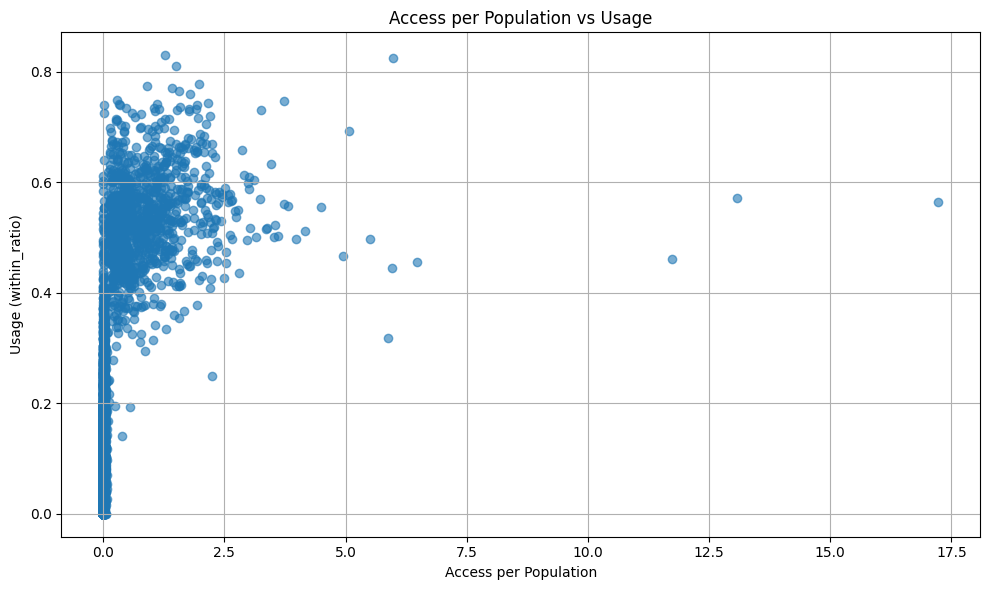

In [38]:
import matplotlib.pyplot as plt

# 计算 access/population，并将结果添加到 merged_data 中
merged_data['access_per_population'] = merged_data['total_poi_count'] / merged_data['population']

# 过滤掉人口为 0 的行以避免除以零
merged_data = merged_data[merged_data['population'] >100]

# 设置图形大小
plt.figure(figsize=(10, 6))

# 绘制散点图
plt.scatter(merged_data['access_per_population'], merged_data['within_ratio'], alpha=0.6)
plt.title('Access per Population vs Usage')
plt.xlabel('Access per Population')
plt.ylabel('Usage (within_ratio)')
plt.grid(True)

# 显示图形
plt.tight_layout()
plt.show()
